# Classifying Attributes that Best Predict Heart Disease

#### Introduction

According to Statistics Canada, heart disease is the second leading cause of death in 2019, accounting for 18.5% of all deaths. So by using the Heart Disease data set, we will determine the three attributes (i.e. characteristics or factors) that can best predict the presence of heart disease in a person. 
The data set contains four datasets concerning heart-disease related characteristics, and each data set contains 14 attributes organized into 14 variables and 302 observations. All the data is of type double, and they were collected from the following institutes:
1. Cleveland Clinic Foundation (cleveland.data)
2. Hungarian Institute of Cardiology, Budapest (hungarian.data)
3. V.A. Medical Center, Long Beach, CA (long-beach-va.data)
4. University Hospital, Zurich, Switzerland (switzerland.data)


#### Preliminary Exploratory Data Analysis

In [15]:
library(tidyverse)
library(repr)
library(broom)
library(GGally)
library(tidymodels)
library(data.table)
options(repr.matrix.max.rows = 6)

In [16]:
set.seed(2000)

heart_disease <- read_csv(url('https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'))

Warning message:
“Duplicated column names deduplicated: '1.0' => '1.0_1' [3], '1.0' => '1.0_2' [6], '0.0' => '0.0_1' [12]”
Parsed with column specification:
cols(
  `63.0` = col_double(),
  `1.0` = col_double(),
  `1.0_1` = col_double(),
  `145.0` = col_double(),
  `233.0` = col_double(),
  `1.0_2` = col_double(),
  `2.0` = col_double(),
  `150.0` = col_double(),
  `0.0` = col_double(),
  `2.3` = col_double(),
  `3.0` = col_double(),
  `0.0_1` = col_character(),
  `6.0` = col_character(),
  `0` = col_double()
)



We set the seed so our code is reproduceable and loaded in our heart disease data.

In [17]:
names(heart_disease) <- c("age", "sex", "chest_pain_type", "resting_bp", "chol", "fasting_blood_sugar", "resting_electrocardiographic_results", "maximum_heart_rate_achieved", "exercise_induced_angina", "oldpeak", "slope", "ca", "thal", "presence_of_h_d")

heart_disease_select_data <- heart_disease %>%
select(-chest_pain_type, -fasting_blood_sugar, -resting_electrocardiographic_results, -exercise_induced_angina, -oldpeak, -slope, -thal, -ca, -sex)

heart_disease_data_0 <- heart_disease_select_data %>%
filter(presence_of_h_d == 0)

heart_disease_data_1 <- heart_disease_select_data %>%
filter(presence_of_h_d > 0) %>%
mutate(presence_of_h_d = 1)

heart_disease_data <- rbind(heart_disease_data_0, heart_disease_data_1) %>% 
mutate(presence_of_h_d = as_factor(presence_of_h_d))

Tidying and cleaning the data. We decided to remove sex since it is categorical so we can't use it.

In [52]:
heart_split <- initial_split(heart_disease_data, prop = 0.66, strata = presence_of_h_d) 
training_data <- training(heart_split) 
testing_data <- testing(heart_split)

Here, we are split the tidied heart disease data into training and testing data. We chose to split 66% of the data for training as it was recommended in the readings to split training to testing in a 2:1 ratio.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



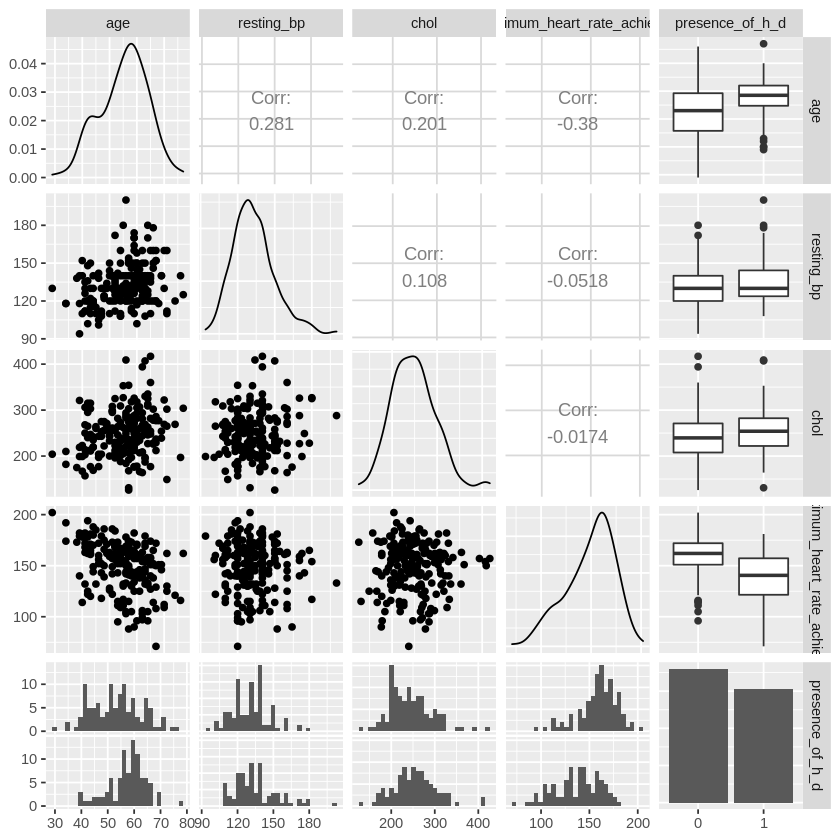

In [19]:
ggpairs(training_data)

Scaled the training data

In [20]:
data_mean <- modify(training_data, mean) %>% head(1)

data_mean

Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”


age,resting_bp,chol,maximum_heart_rate_achieved,presence_of_h_d
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
55.235,132.84,248.2,149.16,NA


Note:
There is no missing data in the training data set.

#### Visualization example

All predictors, serves as our baseline reference.

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6568627
kap,binary,0.2997254


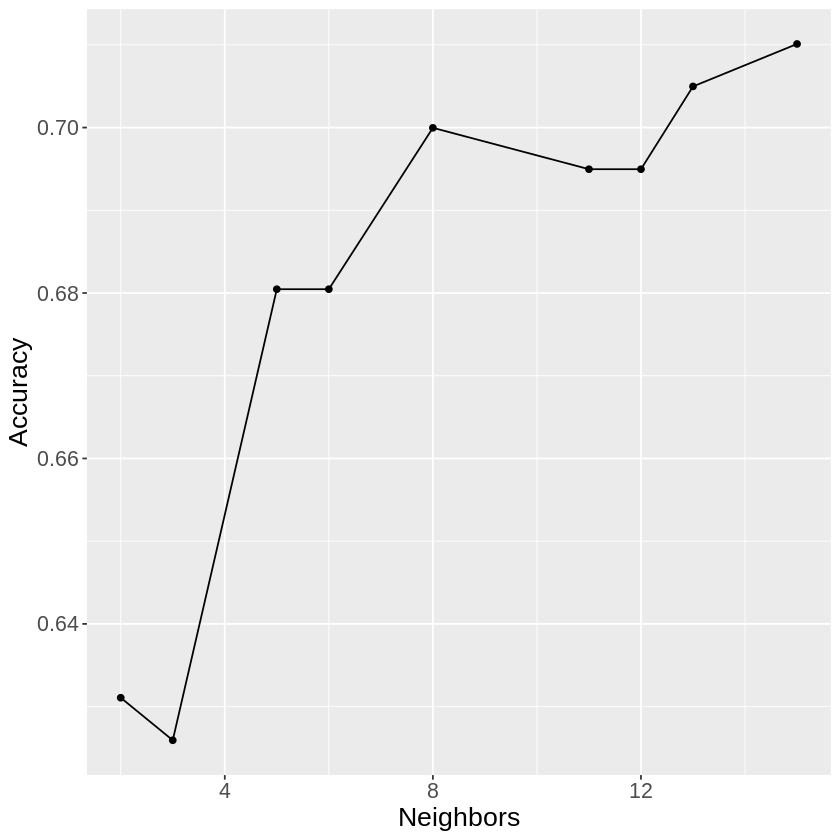

In [33]:
set.seed(2000)
#Recipe
recipe <- recipe(presence_of_h_d ~ ., data = training_data) %>% step_scale(all_predictors()) %>% step_center(all_predictors())
recipe
#vfolds
train_vfold <- vfold_cv(training_data, v = 5, strata = presence_of_h_d)
#specs
spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")

training_fit <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(spec) %>%
      tune_grid(resamples = train_vfold, grid = 10) %>%
      collect_metrics() 

# training_fit

accuracies <- training_fit %>% 
      filter(.metric == "accuracy")

cross_val_plot <- accuracies %>%
     ggplot(aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy") +
     theme(text = element_text (size = 16))

cross_val_plot

k_for_all <- 13

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_for_all) %>%
      set_engine("kknn") %>%
      set_mode("classification")

fit <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(spec) %>%
      fit(data = training_data)

predictions_all <-predict(fit, testing_data) %>% bind_cols(testing_data) %>% metrics(truth = presence_of_h_d, estimate = .pred_class)
predictions_all


1. Using only Age (age) as a predictor

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.5400125,5,0.03412073,Model1
3,accuracy,binary,0.5799093,5,0.04368855,Model2
5,accuracy,binary,0.5990432,5,0.03348141,Model3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,accuracy,binary,0.6256785,5,0.02561372,Model7
13,accuracy,binary,0.6052939,5,0.02257616,Model8
15,accuracy,binary,0.6306911,5,0.01792826,Model9


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6372549
kap,binary,0.2711472


          Truth
Prediction  0  1
         0 28 26
         1 27 21

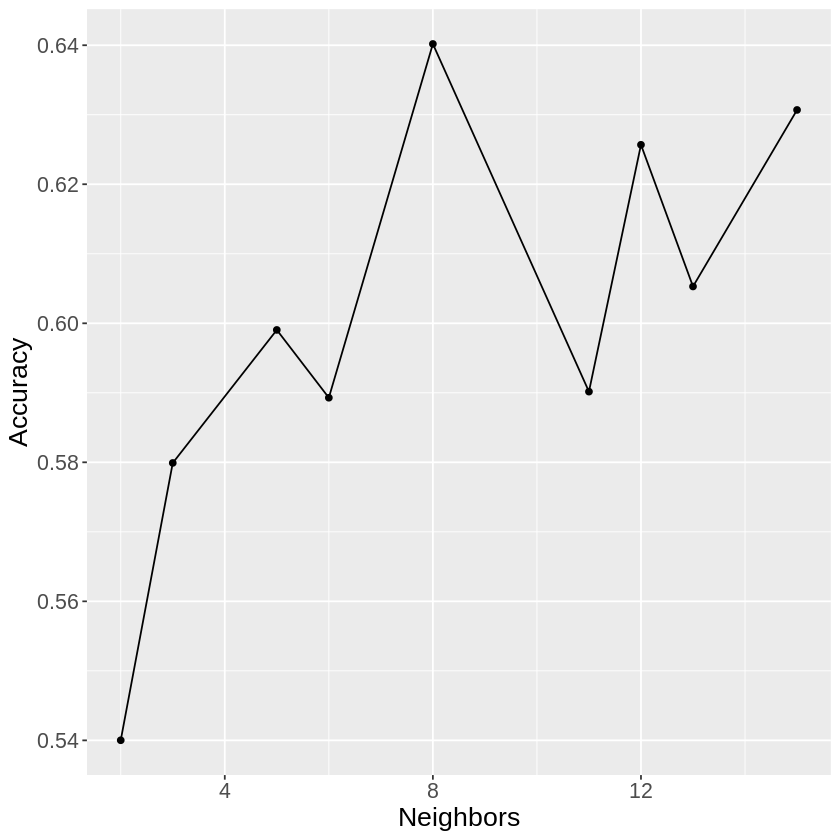

In [53]:
set.seed(2000)
recipe_age <- recipe(presence_of_h_d ~ age, data = training_data) %>% step_scale(all_predictors()) %>% step_center(all_predictors())

train_vfold_age <- vfold_cv(training_data, v = 5, strata = presence_of_h_d)

spec_age <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")

training_fit_age <- workflow() %>%
      add_recipe(recipe_age) %>%
      add_model(spec_age) %>%
      tune_grid(resamples = train_vfold_age, grid = 10) %>%
      collect_metrics() 

# training_fit

accuracies_age <- training_fit_age %>% 
      filter(.metric == "accuracy")

cross_val_plot_age <- accuracies_age %>%
     ggplot(aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy") +
     theme(text = element_text (size = 16))

cross_val_plot_age

k_for_all_age <- accuracies_age %>% arrange(desc(mean)) %>% head(1) %>% pull(neighbors)
accuracies_age

spec_age_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = k_for_all_age) %>%
      set_engine("kknn") %>%
      set_mode("classification")

fit_age <- workflow() %>%
      add_recipe(recipe_age) %>%
      add_model(spec_age_tune) %>%
      fit(data = training_data)

predictions_all_age <-predict(fit_age, testing_data) %>% bind_cols(testing_data) %>% metrics(truth = presence_of_h_d, estimate = .pred_class)
predictions_all
predictions_matixs_age <- predict(fit_age, testing_data) %>% bind_cols(testing_data)%>%
     conf_mat(truth=presence_of_h_d,estimate=.pred_class)
predictions_matixs_age

#Pull results
age_accuracy<-predictions_all_age %>% filter(.metric == "accuracy") %>% pull(.estimate)

2. Using only Resting Blood Pressure (resting_bp) as a predictor:

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          1

Operations:

Scaling for all_predictors()
Centering for all_predictors()

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.5343965,5,0.03133077,Model1
3,accuracy,binary,0.4787492,5,0.06136194,Model2
5,accuracy,binary,0.5545372,5,0.02984479,Model3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,accuracy,binary,0.5799156,5,0.02623735,Model7
13,accuracy,binary,0.5751657,5,0.03706432,Model8
15,accuracy,binary,0.5695372,5,0.04680852,Model9


[1] 12

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5392157
kap,binary,0.0446393


          Truth
Prediction  0  1
         0 41 33
         1 14 14

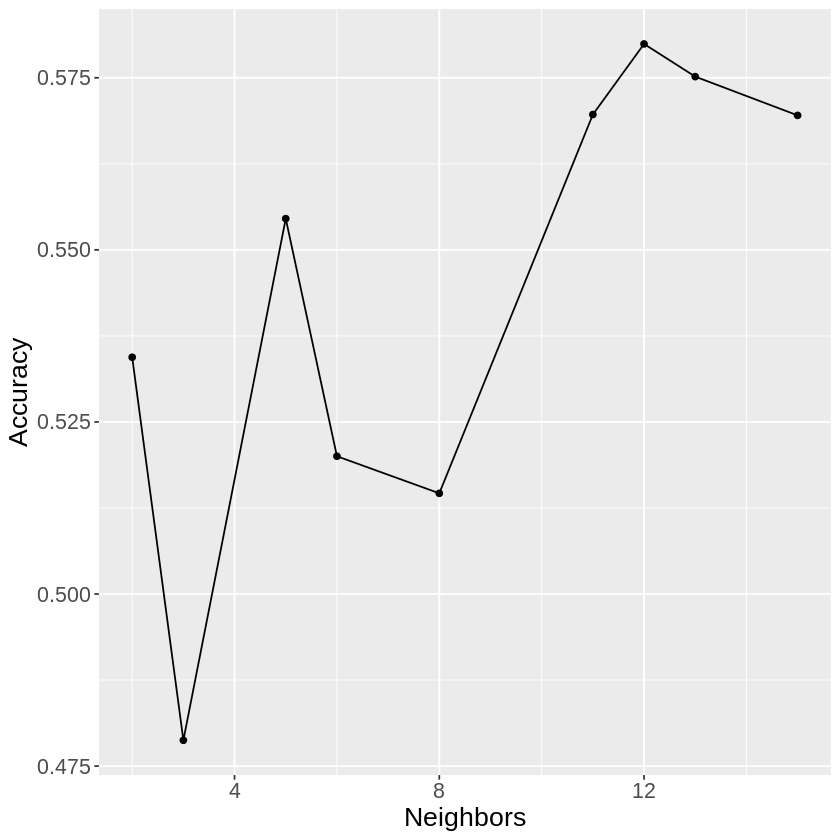

In [54]:
set.seed(2000)
recipe <- recipe(presence_of_h_d ~ resting_bp, data = training_data) %>% step_scale(all_predictors()) %>% step_center(all_predictors())
recipe

train_vfold <- vfold_cv(training_data, v = 5, strata = presence_of_h_d)

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")

training_fit <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(spec) %>%
      tune_grid(resamples = train_vfold, grid = 10) %>%
      collect_metrics() 

# training_fit

accuracies <- training_fit %>% 
      filter(.metric == "accuracy")

cross_val_plot <- accuracies %>%
     ggplot(aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy") +
     theme(text = element_text (size = 16))

cross_val_plot

k_for_all <- accuracies %>% arrange(desc(mean)) %>% head(1) %>% pull(neighbors)
accuracies
k_for_all

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_for_all) %>%
      set_engine("kknn") %>%
      set_mode("classification")

fit <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(spec) %>%
      fit(data = training_data)

predictions_all <-predict(fit, testing_data) %>% bind_cols(testing_data) %>% metrics(truth = presence_of_h_d, estimate = .pred_class)
predictions_all

predictions_matixs <- predict(fit, testing_data) %>% bind_cols(testing_data)%>%
     conf_mat(truth=presence_of_h_d,estimate=.pred_class)
predictions_matixs

#Pull results
bp_accuracy<-predictions_all %>% filter(.metric == "accuracy") %>% pull(.estimate)

3. Using only Cholesterol (chol) as a predictor

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          1

Operations:

Scaling for all_predictors()
Centering for all_predictors()

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.5300188,5,0.023610058,Model1
3,accuracy,binary,0.5754221,5,0.022918336,Model2
5,accuracy,binary,0.5649093,5,0.009930906,Model3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,accuracy,binary,0.4953659,5,0.02690506,Model7
13,accuracy,binary,0.5058787,5,0.02440515,Model8
15,accuracy,binary,0.5105066,5,0.01417569,Model9


[1] 6

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.51960784
kap,binary,0.03177063


          Truth
Prediction  0  1
         0 31 25
         1 24 22

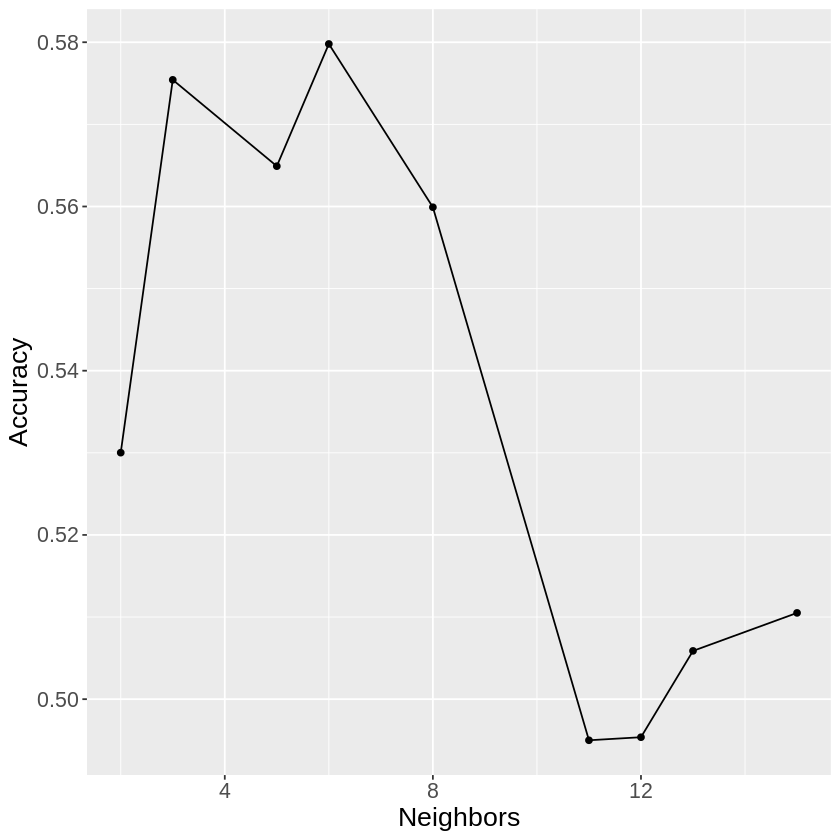

In [55]:
set.seed(2000)
recipe <- recipe(presence_of_h_d ~ chol, data = training_data) %>% step_scale(all_predictors()) %>% step_center(all_predictors())
recipe

train_vfold <- vfold_cv(training_data, v = 5, strata = presence_of_h_d)

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")

training_fit <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(spec) %>%
      tune_grid(resamples = train_vfold, grid = 10) %>%
      collect_metrics() 

# training_fit

accuracies <- training_fit %>% 
      filter(.metric == "accuracy")

cross_val_plot <- accuracies %>%
     ggplot(aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy") +
     theme(text = element_text (size = 16))

cross_val_plot

k_for_all <- accuracies %>% arrange(desc(mean)) %>% head(1) %>% pull(neighbors)
accuracies
k_for_all

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_for_all) %>%
      set_engine("kknn") %>%
      set_mode("classification")

fit <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(spec) %>%
      fit(data = training_data)

predictions_all <-predict(fit, testing_data) %>% bind_cols(testing_data) %>% metrics(truth = presence_of_h_d, estimate = .pred_class)
predictions_all
predictions_matixs <- predict(fit, testing_data) %>% bind_cols(testing_data)%>%
     conf_mat(truth=presence_of_h_d,estimate=.pred_class)
predictions_matixs

#Pull results
chol_accuracy<-predictions_all %>% filter(.metric == "accuracy") %>% pull(.estimate)

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          1

Operations:

Scaling for all_predictors()
Centering for all_predictors()

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.6148061,5,0.02033536,Model1
3,accuracy,binary,0.6652158,5,0.02695632,Model2
5,accuracy,binary,0.6849656,5,0.02642051,Model3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,accuracy,binary,0.6810882,5,0.02541122,Model7
13,accuracy,binary,0.7104784,5,0.01954520,Model8
15,accuracy,binary,0.7154847,5,0.01822189,Model9


[1] 15

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6666667
kap,binary,0.3271246


          Truth
Prediction  0  1
         0 39 18
         1 16 29

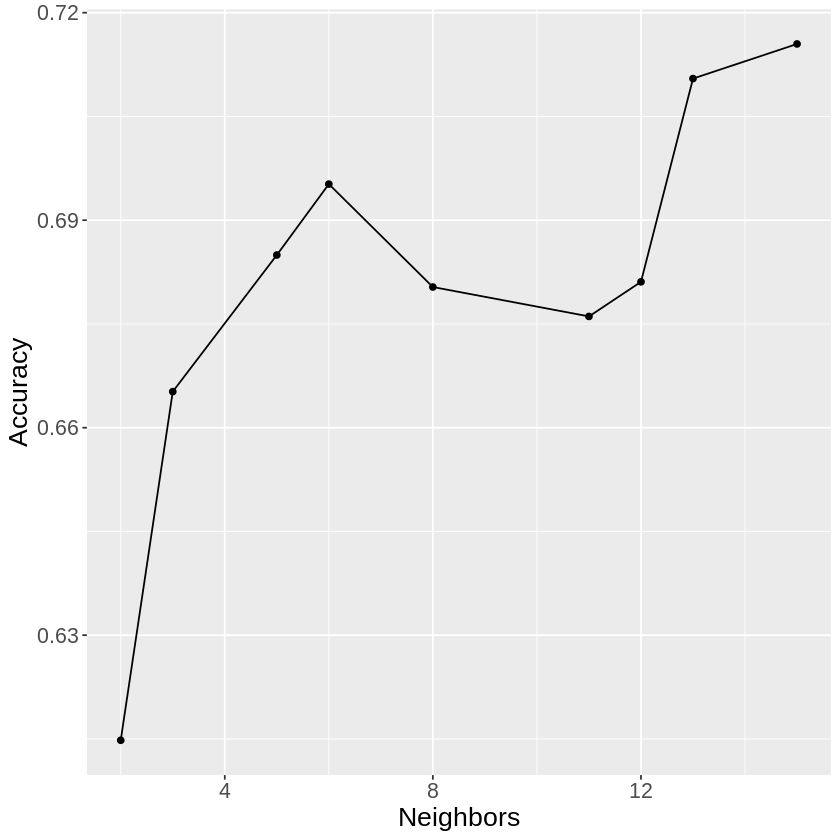

In [56]:
set.seed(2000)
recipe <- recipe(presence_of_h_d ~ maximum_heart_rate_achieved, data = training_data) %>% step_scale(all_predictors()) %>% step_center(all_predictors())
recipe

train_vfold <- vfold_cv(training_data, v = 5, strata = presence_of_h_d)

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")

training_fit <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(spec) %>%
      tune_grid(resamples = train_vfold, grid = 10) %>%
      collect_metrics() 

# training_fit

accuracies <- training_fit %>% 
      filter(.metric == "accuracy")

cross_val_plot <- accuracies %>%
     ggplot(aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy") +
     theme(text = element_text (size = 16))

cross_val_plot

k_for_all <- accuracies %>% arrange(desc(mean)) %>% head(1) %>% pull(neighbors)
accuracies
k_for_all

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_for_all) %>%
      set_engine("kknn") %>%
      set_mode("classification")

fit <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(spec) %>%
      fit(data = training_data)

predictions_all <-predict(fit, testing_data) %>% bind_cols(testing_data) %>% metrics(truth = presence_of_h_d, estimate = .pred_class)
predictions_all
predictions_matixs <- predict(fit, testing_data) %>% bind_cols(testing_data)%>%
     conf_mat(truth=presence_of_h_d,estimate=.pred_class)
predictions_matixs

#Pull results
heart_rate_accuracy<-predictions_all %>% filter(.metric == "accuracy") %>% pull(.estimate)

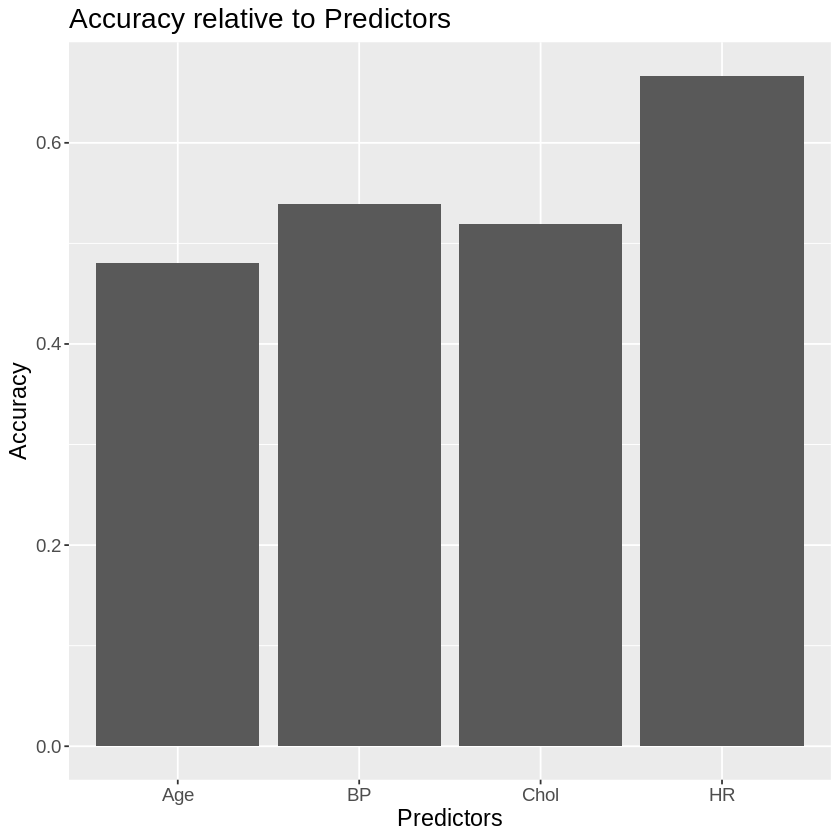

In [57]:
tb <-tibble( `Predictor` = c("Age", "BP", "Chol", "HR"), 'Accuracy' = c(age_accuracy, bp_accuracy, chol_accuracy, heart_rate_accuracy))

plot<- ggplot(tb, aes(x = Predictor, y = Accuracy)) +
        geom_bar(stat="identity") +
        labs(x = "Predictors",y = "Accuracy") +
        ggtitle("Accuracy relative to Predictors") +
        theme(text = element_text(size = 14))
plot

#### Methods

For this project, we will use cleveland.data and the following five factors: age, sex, resting blood pressure, cholesterol level, maximum heart rate achieved, and the presence of heart disease. We chose these attributes because previous research from Texas Heart Institute indicates these as some of the risk factors in developing heart disease.
To conduct our analysis, we will first wrangle the data by selecting and filtering for the data we need and mutating it to be more easily read (e.g. from genders 0 and 1 into female and male). Then we will split the data into training and testing data, where we will train a k-nearest neighbor model using the five attributes as predictors and test it on our test data. Finally, we will use a bar chart to visualize our results and help us determine the top three attributes.


#### Results

#### Discussion

#### References

1. Heart disease risk factors. Texas Heart Institute. (2020, September 30). Retrieved April 4, 2022, from https://www.texasheart.org/heart-health/heart-information-center/topics/heart-disease-risk-factors/  
2. Government Of Canada, S. C. (2020, November 26). Table 1 leading causes of death in Canada, 2019 . Leading causes of death in Canada, 2019. Retrieved April 4, 2022, from https://www150.statcan.gc.ca/n1/daily-quotidien/201126/t001b-eng.htm 
3. Heart Disease Data Set. UCI Machine Learning Repository: Heart disease data set. (n.d.). Retrieved April 4, 2022, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease 